## AI Finance Project - Loda Enrico

In [57]:
!pip install yfinance
#!pip show yfinance

In [90]:
# import
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import scipy.stats as sps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1 - Data Collection and Preparation
We want to calculate the daily simple rate of return of our assets. To do so, we define:

---

**Simple rate of return**  
Given:  
- **P**: the price of the asset at the time of investment  
- **T**: maturity (number of periods)  
- **C**: the price of the asset at maturity **T**

The formula is:
$$
r = \frac{\frac{C}{P} - 1}{T}
$$

---

**Daily simple rate of return:**  
For daily returns, considering $P_t$ as the close price of the asset at time t, the formula is:
$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

In [59]:
df = yf.download(["SPY","NVDA"], start="2010-01-01", end="2025-05-17")
spy = df.xs('SPY', axis=1, level=1)
nvda = df.xs('NVDA', axis=1, level=1)

prices = df["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.dropna()
SPY_r = returns['SPY']
NVDA_r = returns['NVDA']

[*********************100%***********************]  2 of 2 completed


In [60]:
df

Price            Close                    High                     Low  \
Ticker            NVDA         SPY        NVDA         SPY        NVDA   
Date                                                                     
2010-01-04    0.423884   85.768448    0.426864   85.813854    0.415172   
2010-01-05    0.430073   85.995483    0.434659   86.033326    0.422279   
2010-01-06    0.432824   86.056007    0.433741   86.267911    0.425718   
2010-01-07    0.424342   86.419281    0.432366   86.525233    0.421133   
2010-01-08    0.425259   86.706879    0.428239   86.744721    0.418382   
...                ...         ...         ...         ...         ...   
2025-05-12  123.000000  582.989990  123.000000  583.000000  120.279999   
2025-05-13  129.929993  586.840027  131.220001  589.080017  124.470001   
2025-05-14  135.339996  587.590027  135.440002  588.979980  131.679993   
2025-05-15  134.830002  590.460022  136.300003  590.969971  132.660004   
2025-05-16  135.399994  594.200012  136.350006  594.500000  133.460007   

Price                         Open                 Volume             
Ticker             SPY        NVDA         SPY       NVDA        SPY  
Date                                                                  
2010-01-04   84.391067    0.424342   85.041918  800204000  118944600  
2010-01-05   85.405178    0.422279   85.715470  728648000  111579900  
2010-01-06   85.844104    0.429844   85.912213  649168000  116074400  
2010-01-07   85.654909    0.430532   85.897085  547792000  131091100  
2010-01-08   86.018191    0.420903   86.192253  478168000  126402800  
...                ...         ...         ...        ...        ...  
2025-05-12  577.039978  121.970001  581.469971  225023300   78993600  
2025-05-13  582.840027  124.980003  583.409973  330430100   67947200  
2025-05-14  585.539978  133.199997  587.809998  281180800   66283500  
2025-05-15  585.099976  134.289993  585.559998  226632600   71268100  
2025-05-16  589.280029  136.220001  591.250000  226542500   76052100  

[3867 rows x 10 columns]

In [61]:
returns[:]

Ticker,NVDA,SPY
Date,,
2010-01-05,0.014603,0.002647
2010-01-06,0.006396,0.000704
2010-01-07,-0.019598,0.004221
2010-01-08,0.002161,0.003328
2010-01-11,-0.014016,0.001396
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


##dataset for training
The features, for a total of 24, are the following:

*   $\mu_1$, $\mu_2$ of $r_1$, $r_2$ calculated on the last 10 lags
*   $[r_1^t,\dots ,r_1^{t-10}]$, $[r_2^t,\dots ,r_2^{t-10}]$

The target is the values of my covariance matrix:
* $\Sigma_{t+1}$

In [62]:
rNVDA_series = returns['NVDA']
rSPY_series = returns['SPY']
df = pd.DataFrame()
df['rNVDA_today'] = rNVDA_series
df['rSPY_today'] = rSPY_series

for i in range(1, 11):
    df[f'rNVDA_t-{i}'] = rNVDA_series.shift(i)
    df[f'rSPY_t-{i}'] = rSPY_series.shift(i)

df.head(11)

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-6,rSPY_t-6,rNVDA_t-7,rSPY_t-7,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.019598,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002161,0.003328,-0.019598,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,-0.014016,0.001396,0.002161,0.003328,-0.019598,0.004221,0.006396,0.000704,0.014603,0.002647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.019598,0.004221,0.006396,0.000704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,0.013582,0.008446,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.019598,0.004221,...,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,-0.015634,0.002705,0.013582,0.008446,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,...,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.029495,-0.011224,-0.015634,0.002705,0.013582,0.008446,-0.033898,-0.009326,-0.014016,0.001396,...,-0.019598,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN


In [63]:
cols = [f'rNVDA_t-{i}' for i in range(1, 11)]
df['mean_NVDA'] = df[cols].mean(axis=1)
cols.append('rNVDA_today')
df['var_NVDA'] = df[cols].var(axis=1)

cols = [f'rSPY_t-{i}' for i in range(1, 11)]
df['mean_SPY'] = df[cols].mean(axis=1)
cols.append('rSPY_today')
df['var_SPY'] = df[cols].var(axis=1)
df = df.dropna()
df#["r2_t-10"]

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,0.013582,0.008446,...,-0.019598,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059
2010-01-21,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,...,0.002161,0.003328,-0.019598,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093
2010-01-22,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,...,-0.014016,0.001396,0.002161,0.003328,-0.019598,0.004221,-0.010007,0.000327,-0.001736,0.000131
2010-01-25,0.017011,0.005127,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,...,-0.033898,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132
2010-01-26,-0.031661,-0.004190,0.017011,0.005127,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,...,0.013582,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010022,0.000424,-0.004207,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,-0.000917,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127
2025-05-13,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.024697,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124
2025-05-14,0.041638,0.001278,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,...,0.025894,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126


In [64]:
count = (df['var_SPY'] > df['var_NVDA']).sum()
print(f"The number of times 'var_SPY' is larger than 'var_NVDA' is: {count}")

The number of times 'var_SPY' is larger than 'var_NVDA' is: 23


In [65]:
def compute_covariance_row(row):
    r1 = [row[f'rNVDA_t-{i}'] for i in range(1, 11)]
    r1.append(row['rNVDA_today'])

    r2 = [row[f'rSPY_t-{i}'] for i in range(1, 11)]
    r2.append(row['rSPY_today'])

    return np.cov(r1, r2)[0, 1]

df['cov'] = df.apply(compute_covariance_row, axis=1)
df

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,0.013582,0.008446,...,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,...,0.003328,-0.019598,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,...,0.001396,0.002161,0.003328,-0.019598,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,0.017011,0.005127,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,...,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,-0.031661,-0.004190,0.017011,0.005127,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,...,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010022,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127,0.000202
2025-05-13,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124,0.000190
2025-05-14,0.041638,0.001278,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,...,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126,0.000181


In [66]:
df_r = df.loc[:][['rNVDA_today', 'rSPY_today']]
df.drop(['rNVDA_today', 'rSPY_today'], axis=1, inplace=True)
df

,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,rNVDA_t-5,rSPY_t-5,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,0.013582,0.008446,-0.033898,-0.009326,...,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,0.013582,0.008446,...,0.003328,-0.019598,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002705,...,0.001396,0.002161,0.003328,-0.019598,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,-0.029495,-0.011224,...,-0.009326,-0.014016,0.001396,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,0.017011,0.005127,-0.034604,-0.022291,-0.017857,-0.019229,-0.004016,-0.010169,0.018702,0.012495,...,0.008446,-0.033898,-0.009326,-0.014016,0.001396,-0.010022,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,-0.005939,-0.005734,...,0.000397,0.002667,0.006299,-0.020539,0.000381,0.005092,0.000471,0.002482,0.000127,0.000202
2025-05-13,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,-0.002460,-0.008358,...,0.007087,-0.000917,0.000397,0.002667,0.006299,0.012589,0.000545,0.005748,0.000124,0.000190
2025-05-14,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.002648,0.006968,0.031002,0.004206,...,0.014844,0.024697,0.007087,-0.000917,0.000397,0.017957,0.000575,0.005779,0.000126,0.000181


In [67]:
df_r

,rNVDA_today,rSPY_today
Date,,
2010-01-20,-0.004016,-0.010169
2010-01-21,-0.017857,-0.019229
2010-01-22,-0.034604,-0.022291
2010-01-25,0.017011,0.005127
2010-01-26,-0.031661,-0.004190
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


### we are trying to scale in order to have numerical stability, we are not sure it is correct since we need to have the non-scaled version of the variance at inference time

In [68]:
train_df = df.loc["2010-01-01":"2022-12-31"]
validation_df = df.loc["2023-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":]
print((len(train_df) + len(validation_df) + len(test_df)) == len(df))


##CARE FOR SCALER
#scaler = StandardScaler()
#scaler.fit(train_df)
#train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
#test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

True


Flip the columns in order to have a temporal sequence from past to present

In [69]:
train_df = train_df[train_df.columns[::-1]]
validation_df = validation_df[validation_df.columns[::-1]]
test_df = test_df[test_df.columns[::-1]]

In [70]:
train_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.000097,0.000059,0.001539,0.000331,-0.005720,0.002647,0.014603,0.000704,0.006396,0.004221,...,-0.009326,-0.033898,0.008446,0.013582,0.002705,-0.015634,-0.011224,-0.029495,0.012495,0.018702
2010-01-21,0.000111,0.000093,0.000258,0.000296,-0.007581,0.000704,0.006396,0.004221,-0.019598,0.003328,...,0.008446,0.013582,0.002705,-0.015634,-0.011224,-0.029495,0.012495,0.018702,-0.010169,-0.004016
2010-01-22,0.000153,0.000131,-0.001736,0.000327,-0.010007,0.004221,-0.019598,0.003328,0.002161,0.001396,...,0.002705,-0.015634,-0.011224,-0.029495,0.012495,0.018702,-0.010169,-0.004016,-0.019229,-0.017857
2010-01-25,0.000184,0.000132,-0.004387,0.000395,-0.011507,0.003328,0.002161,0.001396,-0.014016,-0.009326,...,-0.011224,-0.029495,0.012495,0.018702,-0.010169,-0.004016,-0.019229,-0.017857,-0.022291,-0.034604
2010-01-26,0.000175,0.000127,-0.004207,0.000424,-0.010022,0.001396,-0.014016,-0.009326,-0.033898,0.008446,...,0.012495,0.018702,-0.010169,-0.004016,-0.019229,-0.017857,-0.022291,-0.034604,0.005127,0.017011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.000335,0.000156,-0.003457,0.000964,-0.010718,-0.007470,-0.009785,0.014417,0.031410,0.007570,...,-0.011806,-0.022475,-0.008480,-0.019130,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420
2022-12-27,0.000345,0.000154,-0.002135,0.001299,-0.010607,0.014417,0.031410,0.007570,0.030624,-0.006393,...,-0.008480,-0.019130,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420,0.005752,-0.008671
2022-12-28,0.000246,0.000129,-0.003971,0.001070,-0.020883,0.007570,0.030624,-0.006393,-0.022023,-0.024462,...,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420,0.005752,-0.008671,-0.003944,-0.071353


In [82]:
test_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.000084,0.000042,0.001121,0.000290,0.002503,-0.001647,0.011169,0.005625,0.024279,0.006081,...,0.002010,-0.003266,0.004222,0.009195,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000
2024-01-03,0.000096,0.000048,0.000726,0.000287,-0.001348,0.005625,0.024279,0.006081,-0.009445,-0.013857,...,0.004222,0.009195,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341
2024-01-04,0.000076,0.000045,-0.000653,0.000227,-0.005020,0.006081,-0.009445,-0.013857,-0.030098,0.009482,...,0.001808,0.002800,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436
2024-01-05,0.000087,0.000041,-0.001584,0.000285,-0.003173,-0.013857,-0.030098,0.009482,0.018270,0.002010,...,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019
2024-01-08,0.000128,0.000042,-0.000061,0.000542,0.002126,0.009482,0.018270,0.002010,-0.003266,0.004222,...,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019,0.001370,0.022897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12,0.000202,0.000127,0.002482,0.000471,0.005092,0.000381,-0.020539,0.006299,0.002667,0.000397,...,-0.005734,-0.005939,-0.008358,-0.002460,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134
2025-05-13,0.000190,0.000124,0.005748,0.000545,0.012589,0.006299,0.002667,0.000397,-0.000917,0.007087,...,-0.008358,-0.002460,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134,0.033047,0.054436
2025-05-14,0.000181,0.000126,0.005779,0.000575,0.017957,0.000397,-0.000917,0.007087,0.024697,0.014844,...,0.004206,0.031002,0.006968,0.002648,-0.001274,-0.006134,0.033047,0.054436,0.006604,0.056341


In [71]:
scaler_feature  = StandardScaler()
scaler_target = StandardScaler()

class LSTMdataset(Dataset):
    def __init__(self, dataframe, train):
        super().__init__()

        feature_dataframe = dataframe.drop(['cov', 'var_NVDA', 'var_SPY'], axis=1)
        target_dataframe = dataframe[['cov', 'var_NVDA', 'var_SPY']]

        if train:
          feature_dataframe = scaler_feature.fit_transform(feature_dataframe)
          target_dataframe = scaler_target.fit_transform(target_dataframe)
        else:
          feature_dataframe = scaler_feature.transform(feature_dataframe)
          target_dataframe = scaler_target.transform(target_dataframe)

        self.X = torch.tensor(feature_dataframe, dtype=torch.float32)
        self.y = torch.tensor(target_dataframe, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [72]:
# pre normalization
col_names = ['cov', 'var_NVDA', 'var_SPY']
for name in col_names:
    print(f"{name}: min={train_df[name].min():.6f}, max={train_df[name].max():.6f}")

cov: min=-0.000185, max=0.007358
var_NVDA: min=0.000019, max=0.011850
var_SPY: min=0.000002, max=0.004897


In [73]:
# post normalization
train_dataset = LSTMdataset(train_df, train=True)
train_dataset[3]


# Get all targets from the dataset as a tensor
all_targets = train_dataset[:][1]  # shape: (num_samples, 3)

# Convert to numpy array
all_targets_np = all_targets.numpy()

# Print min and max for each column (cov, var_NVDA, var_SPY)
col_names = ['cov', 'var_NVDA', 'var_SPY']
for i, name in enumerate(col_names):
    print(f"{name}: min={all_targets_np[:, i].min():.6f}, max={all_targets_np[:, i].max():.6f}")

cov: min=-0.866765, max=16.036280
var_NVDA: min=-0.747649, max=10.675820
var_SPY: min=-0.411307, max=15.820741


In [74]:
# batch first lets us have the tensor in the shape (batch=32, sequence=10, feature=2)
class LSTM(torch.nn.Module):
    def __init__(self, input_size=2, hidden_size=20, num_layers=2, output_size=3, dropout=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm  = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
          )
        # hidden size + 2 since the fc will take in input the mean of each asset
        self.fc_1 = torch.nn.Linear (hidden_size+2, (hidden_size+2)//2)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc_2 = torch.nn.Linear ((hidden_size+2)//2, output_size)

    # x_lstm = (32, 10, 2) [N,L,H_in]
    # x_means = (32,2)
    def forward (self, x_lstm, x_means):

      output_lstm, _ = self.lstm(x_lstm)

      # now x_lstm = (32, 10, hidden_size)[N,L,Hout​]
      # here we take only the last hidden state
      last_hidden_state = output_lstm[:,-1,:]

      # now last_hidden_state should be (32,hidden_size)

      x_cat = torch.cat([last_hidden_state, x_means], dim=1)
      x_out = self.fc_1(x_cat)
      x_out = torch.relu(x_out)
      x_out = self.dropout(x_out)
      x_out = self.fc_2(x_out)
      return x_out

## We use train and validation to fix hyperparameters

In [75]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            #reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            optimizer.zero_grad()
            outputs = model(x_lstm, x_means)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")


def evaluate_model(model, data_loader, criterion_mse, criterion_mae, device):
    predictions = []
    model.eval()  # Set the model to evaluation mode
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            # reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            outputs = model(x_lstm, x_means)

            loss_mse = criterion_mse(outputs, y)
            loss_mae = criterion_mae(outputs, y)

            predictions.append(scaler_target.inverse_transform(outputs.cpu()))

            total_mse += loss_mse.item() * X.size(0)
            total_mae += loss_mae.item()
            num_samples += X.size(0)

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, predictions

In [76]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
#learning_rate = 1e-4
weight_decay=1e-4
epochs = 50

# Prepare datasets and dataloaders
#print(train_df[-1:])
train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Device setup: CUDA > MPS (Mac) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Model, loss, optimizer
model_val = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model_val.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model_val, train_loader, criterion, optimizer, epochs, device)


Using device: cpu
Epoch 1/50, Loss: 1.024886
Epoch 2/50, Loss: 0.998886
Epoch 3/50, Loss: 0.972289
Epoch 4/50, Loss: 0.849097
Epoch 5/50, Loss: 0.703259
Epoch 6/50, Loss: 0.611300
Epoch 7/50, Loss: 0.633590
Epoch 8/50, Loss: 0.545899
Epoch 9/50, Loss: 0.578549
Epoch 10/50, Loss: 0.508010
Epoch 11/50, Loss: 0.505607
Epoch 12/50, Loss: 0.422948
Epoch 13/50, Loss: 0.405192
Epoch 14/50, Loss: 0.390168
Epoch 15/50, Loss: 0.480608
Epoch 16/50, Loss: 0.515821
Epoch 17/50, Loss: 0.284325
Epoch 18/50, Loss: 0.271899
Epoch 19/50, Loss: 0.287320
Epoch 20/50, Loss: 0.305844
Epoch 21/50, Loss: 0.398666
Epoch 22/50, Loss: 0.337497
Epoch 23/50, Loss: 0.306583
Epoch 24/50, Loss: 0.308163
Epoch 25/50, Loss: 0.276627
Epoch 26/50, Loss: 0.275438
Epoch 27/50, Loss: 0.326536
Epoch 28/50, Loss: 0.295032
Epoch 29/50, Loss: 0.285166
Epoch 30/50, Loss: 0.351772
Epoch 31/50, Loss: 0.344738
Epoch 32/50, Loss: 0.383865
Epoch 33/50, Loss: 0.342603
Epoch 34/50, Loss: 0.316451
Epoch 35/50, Loss: 0.286003
Epoch 36/50

## Validation

In [77]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')

validation_dataset = LSTMdataset(validation_df, train=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

model_val.eval()
val_mse = 0.0
val_mae = 0.0
avg_val_mse, avg_val_mae, _ = evaluate_model(model_val, val_loader, mse, mae, device)

print(f"Validation MSE: {avg_val_mse:.6f}")
print(f"Validation MAE: {avg_val_mae:.6f}")

Validation MSE: 0.186437
Validation MAE: 0.568910


##now train on whole dataset

In [78]:
train_df = pd.concat([train_df, validation_df])

train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model, train_loader, criterion, optimizer, epochs, device)


Epoch 1/50, Loss: 0.997391
Epoch 2/50, Loss: 0.978227
Epoch 3/50, Loss: 0.949335
Epoch 4/50, Loss: 0.751565
Epoch 5/50, Loss: 0.692894
Epoch 6/50, Loss: 0.599642
Epoch 7/50, Loss: 0.567088
Epoch 8/50, Loss: 0.461676
Epoch 9/50, Loss: 0.552434
Epoch 10/50, Loss: 0.508278
Epoch 11/50, Loss: 0.495079
Epoch 12/50, Loss: 0.438296
Epoch 13/50, Loss: 0.383250
Epoch 14/50, Loss: 0.403685
Epoch 15/50, Loss: 0.345043
Epoch 16/50, Loss: 0.310970
Epoch 17/50, Loss: 0.299459
Epoch 18/50, Loss: 0.309818
Epoch 19/50, Loss: 0.292971
Epoch 20/50, Loss: 0.287524
Epoch 21/50, Loss: 0.269718
Epoch 22/50, Loss: 0.325698
Epoch 23/50, Loss: 0.361378
Epoch 24/50, Loss: 0.284076
Epoch 25/50, Loss: 0.266596
Epoch 26/50, Loss: 0.261423
Epoch 27/50, Loss: 0.270098
Epoch 28/50, Loss: 0.287511
Epoch 29/50, Loss: 0.409095
Epoch 30/50, Loss: 0.359828
Epoch 31/50, Loss: 0.246159
Epoch 32/50, Loss: 0.255151
Epoch 33/50, Loss: 0.272630
Epoch 34/50, Loss: 0.265954
Epoch 35/50, Loss: 0.276121
Epoch 36/50, Loss: 0.292428
E

In [79]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')
#drop the last year, from
#test_df = test_df.loc[:"2024-12-31"]
#print last element
print(test_df[-1:])
test_dataset = LSTMdataset(test_df, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_mse = 0.0
test_mae = 0.0

avg_test_mse, avg_test_mae, predictions = evaluate_model(model, test_loader, mse, mae, device)

print(f"Test MSE: {avg_test_mse:.6f}")
print(f"Test MAE: {avg_test_mae:.6f}")

                cov   var_SPY  mean_SPY  var_NVDA  mean_NVDA  rSPY_t-10  \
Date                                                                      
2025-05-16  0.00017  0.000123  0.005646  0.000606   0.019366   0.014844   

            rNVDA_t-10  rSPY_t-9  rNVDA_t-9  rSPY_t-8  ...  rSPY_t-5  \
Date                                                   ...             
2025-05-16    0.025894 -0.005734  -0.005939 -0.008358  ... -0.001274   

            rNVDA_t-5  rSPY_t-4  rNVDA_t-4  rSPY_t-3  rNVDA_t-3  rSPY_t-2  \
Date                                                                        
2025-05-16  -0.006134  0.033047   0.054436  0.006604   0.056341  0.001278   

            rNVDA_t-2  rSPY_t-1  rNVDA_t-1  
Date                                        
2025-05-16   0.041638  0.004884  -0.003768  

[1 rows x 25 columns]
Test MSE: 0.371492
Test MAE: 0.902026


# 2 - Markowitz Portfolio Construction

Create a list of output not considering the batch, then create a dataframe only with the returns

In [83]:
output = []
for pred in predictions:
    for val in pred:
        output.append(val)

test_df_r = df_r.loc["2024-01-01":]

In [84]:
test_df_r

,rNVDA_today,rSPY_today
Date,,
2024-01-02,-0.027341,-0.005596
2024-01-03,-0.012436,-0.008167
2024-01-04,0.009019,-0.003221
2024-01-05,0.022897,0.001370
2024-01-08,0.064281,0.014276
...,...,...
2025-05-12,0.054436,0.033047
2025-05-13,0.056341,0.006604
2025-05-14,0.041638,0.001278


In [86]:
def get_mvp(var1,var2,cov):
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    corr = cov/(std1*std2)
    #print("corr: ",corr)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(return1, return2, w):
    return w * return1 + (1-w)*return2

In [87]:
def run_portfolio_simulation(var_source='real', capital=1000):
    weights_nvda, weights_spy = [], []
    capital_NVDA, capital_SPY = [], []
    portfolio_values = [capital]
    nvda_asset_1 = True

    for day in range(len(test_df)):
        print(f"DAY {day}")
        row = test_df.iloc[day]

        # Update portfolio value
        if day > 0:
            w_old = weights_nvda[day - 1] if nvda_asset_1 else weights_spy[day - 1]
            r_nvda = test_df_r['rNVDA_today'][day - 1]
            r_spy = test_df_r['rSPY_today'][day - 1]
            daily_return = get_return_values(r_nvda, r_spy, w_old)
            new_val = portfolio_values[day - 1] * (1 + daily_return)
            portfolio_values.append(new_val)
            print("UPDATED PORTFOLIO VALUE:", new_val)

        # Retrieve variance & covariance
        if var_source == 'real':
            var_nvda = row['var_NVDA']
            var_spy = row['var_SPY']
            cov = row['cov']
        elif var_source == 'predicted':
            var_nvda = output[day][1]
            var_spy = output[day][2]
            cov = output[day][0]
        else:
            raise ValueError("var_source must be 'real' or 'predicted'")

        nvda_asset_1 = var_nvda >= var_spy

        # Allocation
        if nvda_asset_1:
            w = get_mvp(var_nvda, var_spy, cov)
            w_nvda, w_spy = w, 1 - w
        else:
            w = get_mvp(var_spy, var_nvda, cov)
            w_nvda, w_spy = 1 - w, w

        weights_nvda.append(w_nvda)
        weights_spy.append(w_spy)

        v_nvda, v_spy = get_capital_values(portfolio_values[day], w_nvda)
        capital_NVDA.append(v_nvda)
        capital_SPY.append(v_spy)

        # Print
        if day == 0:
            print("NVDA ALLOCATED:", v_nvda)
            print("SPY ALLOCATED:", v_spy)
        else:
            nvda_diff = v_nvda - capital_NVDA[day - 1]
            spy_diff = v_spy - capital_SPY[day - 1]

            print(f"{'BUY' if nvda_diff > 0 else 'SELL'} NVDA: {abs(nvda_diff)}")
            print(f"ACTUAL NVDA: {v_nvda}")

            print(f"{'BUY' if spy_diff > 0 else 'SELL'} SPY: {abs(spy_diff)}")
            print(f"ACTUAL SPY: {v_spy}")

    print("FINAL PORTFOLIO VALUE:", portfolio_values[-1])
    return portfolio_values, weights_nvda, weights_spy, capital_NVDA, capital_SPY


In [88]:
oracle_result, weights_nvda_oracle, weights_spy_oracle, capital_NVDA_oracle, capital_SPY_oracle = run_portfolio_simulation(var_source='real')

predicted_result, weights_nvda_pred, weights_spy_pred, capital_NVDA_pred, capital_SPY_pred = run_portfolio_simulation(var_source='predicted')

DAY 0
NVDA ALLOCATED: -263.1636618259869
SPY ALLOCATED: 1263.163661825987
DAY 1
UPDATED PORTFOLIO VALUE: 1000.1262320746989
SELL NVDA: 71.22667836835058
ACTUAL NVDA: -334.39034019433745
BUY SPY: 71.3529104430495
ACTUAL SPY: 1334.5165722690365
DAY 2
UPDATED PORTFOLIO VALUE: 993.3860761430433
BUY NVDA: 79.2760857253705
ACTUAL NVDA: -255.11425446896695
SELL SPY: 86.01624165702628
ACTUAL SPY: 1248.5003306120102
DAY 3
UPDATED PORTFOLIO VALUE: 987.0637711643577
SELL NVDA: 50.60318905099021
ACTUAL NVDA: -305.71744351995716
BUY SPY: 44.28088407230484
ACTUAL SPY: 1292.781214684315
DAY 4
UPDATED PORTFOLIO VALUE: 981.8344966610468
BUY NVDA: 48.38266201710974
ACTUAL NVDA: -257.3347815028474
SELL SPY: 53.61193652042084
ACTUAL SPY: 1239.1692781638942
DAY 5
UPDATED PORTFOLIO VALUE: 982.9830405926139
BUY NVDA: 21.561628040470993
ACTUAL NVDA: -235.77315346237643
SELL SPY: 20.41308410890383
ACTUAL SPY: 1218.7561940549904
DAY 6
UPDATED PORTFOLIO VALUE: 977.1319083155984
SELL NVDA: 26.632579089208008
ACTU

<ipython-input-87-4b0fd45568c8>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_nvda = test_df_r['rNVDA_today'][day - 1]
<ipython-input-87-4b0fd45568c8>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_spy = test_df_r['rSPY_today'][day - 1]


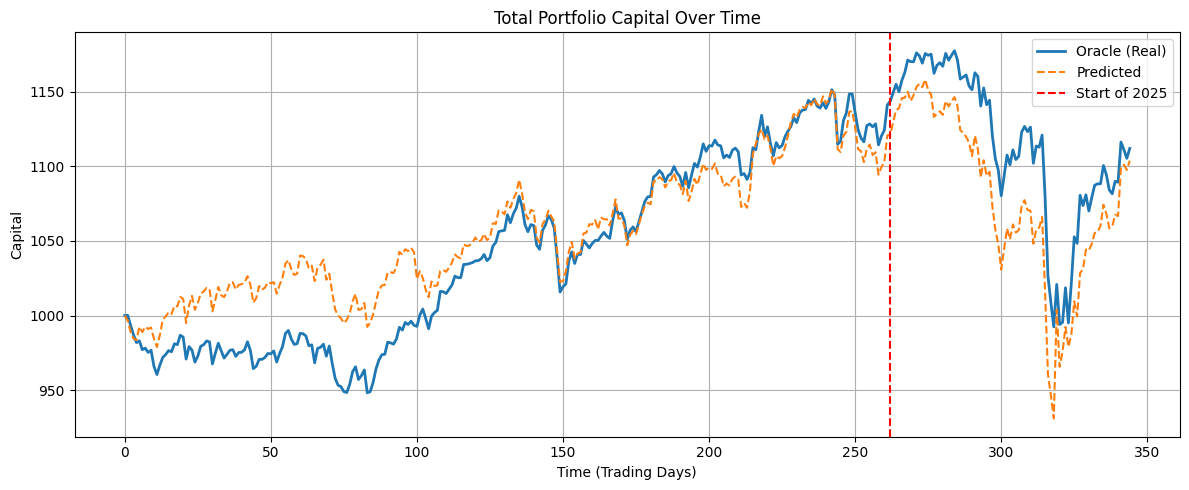

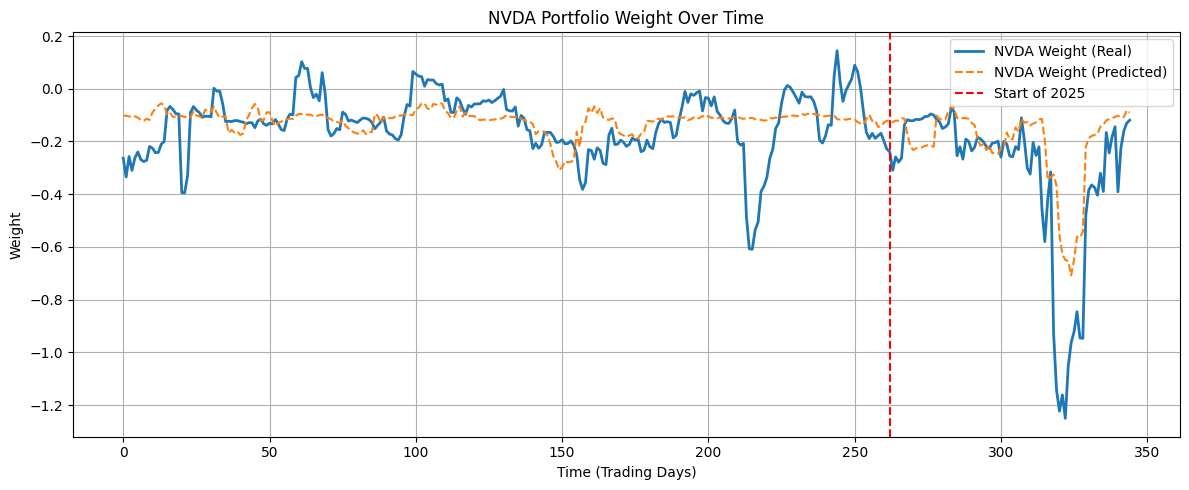

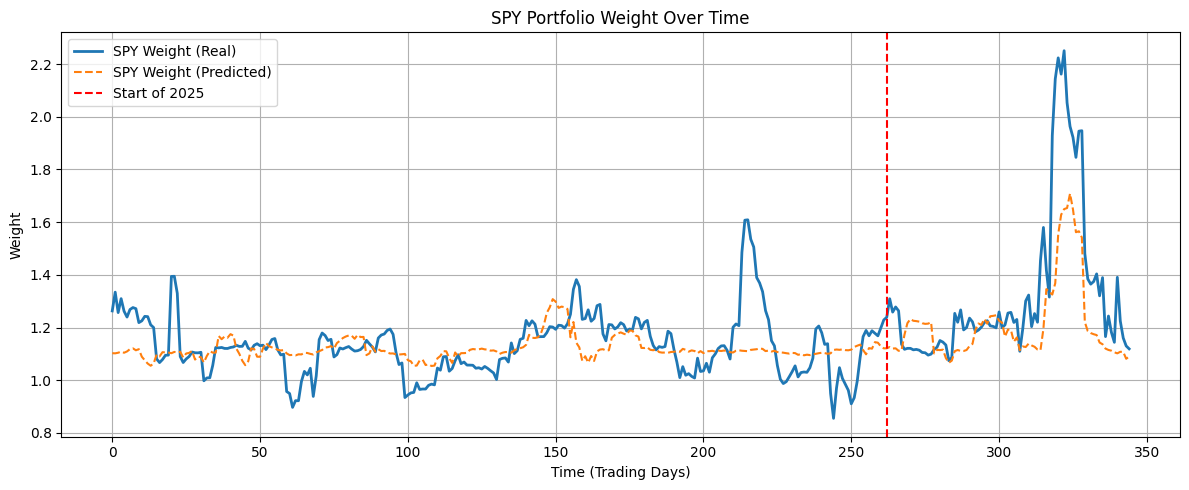

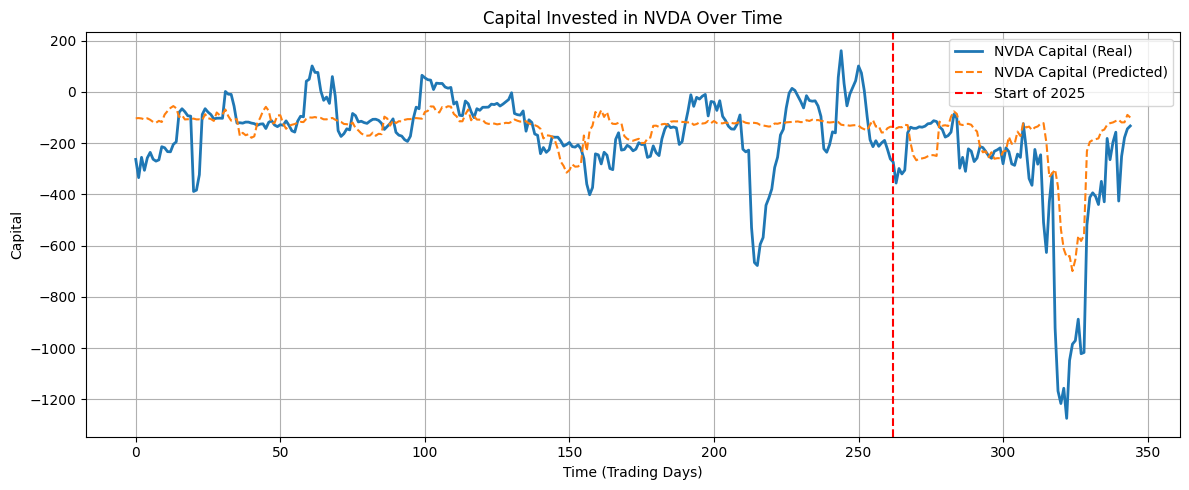

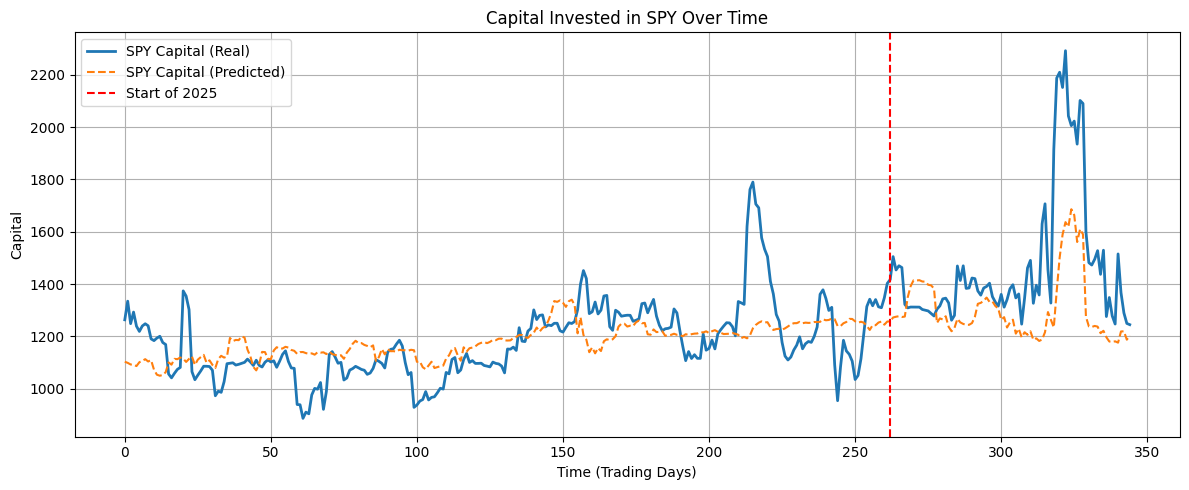

In [91]:

trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

time = list(range(len(oracle_result)))

# --- Total portfolio capital over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, oracle_result, label='Oracle (Real)', linewidth=2)
plt.plot(time, predicted_result, label='Predicted', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Total Portfolio Capital Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- NVDA weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, weights_nvda_oracle, label='NVDA Weight (Real)', linewidth=2)
plt.plot(time, weights_nvda_pred, label='NVDA Weight (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('NVDA Portfolio Weight Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SPY weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, weights_spy_oracle, label='SPY Weight (Real)', linewidth=2)
plt.plot(time, weights_spy_pred, label='SPY Weight (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('SPY Portfolio Weight Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Capital invested in NVDA over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, capital_NVDA_oracle, label='NVDA Capital (Real)', linewidth=2)
plt.plot(time, capital_NVDA_pred, label='NVDA Capital (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in NVDA Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Capital invested in SPY over time ---
plt.figure(figsize=(12, 5))
plt.plot(time, capital_SPY_oracle, label='SPY Capital (Real)', linewidth=2)
plt.plot(time, capital_SPY_pred, label='SPY Capital (Predicted)', linestyle='--')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in SPY Over Time')
plt.xlabel('Time (Trading Days)')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 3 Stress Testing Framework


## base case

In [ ]:
def get_VaR(alpha, mean, std):
  # norm.ppf(q, loc, scale) gives you the value x such that P(X ≤ x) = q for a normal distribution with mean loc and standard deviation scale.
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
  #This function approximates ES by averaging 40 quantiles beyond the VaR threshold.
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

# 4 - Model Evaluation and Backtesting